# 이전 모델은 성능이 엉망이다.
- 파일 분리시 단순 아이피가 아닌 보고서에 나온 알고리즘으로 접근하자
- xml-rpc 사용자와 이상패턴 호스트 군은 제외하고 분류 모델을 제작한다.
    - 대회 주제에서 벗어난다.
    - 다량 접근이 발생하는 상황에서도 특정 공격을 분류하는 모델을 만들어야한다.

- 모델을 각 공격별로 만들어야한다.
- 예상 시스템 진행도
    - input으로 로그.csv를 넣는다.
    - 1분 단위로 절삭(이상행위는 짧은 시간동안 주기적인 성향을 보이기 때문에)
    - 절삭 csv파일을 이미지화
    - 이미지가 모델 A에 의해 분류 되고 데이터 프레임에 기록된다.
    - 이미지가 모델 B에 의해 분류 되고 데이터 프레임에 기록된다.
    - 이미지가 모델 C에 의해 분류 되고 데이터 프레임에 기록된다.
    - 파일명과 대조하여 모델 A, B, C로부터 잘 분류 되었는지 판단.
        - 예상 결과
        - 파일명 : 2020-08-xx_xx:xx.csv
        - A 공격 : 0
        - B 공격 : 1
        - C 공격 : 1
            - 판독 : 해당 시간은 B와 C 공격에대한 이상행위 접근이 있었다.
    - 모델 평가시 실제 데이터 프레임과 대조하여 분류 정확도를 측정한다.
        
## 크루덴셜 스터핑 분류 모델
- ['Payload']에 log, pwd가 포함된 로그는 새로운 컬럼['Crudential']에 1을 추가한다. 
- 1분 단위로 파일을 절단하고 파일명에 공격 여부 기록.
- 절삭된 csv 파일에서 ['Timestamp'], ['Host'], ['UA'], ['Crudential'] 컬럼을 삭제하여 특정화된 정보가 공격으로 분류 될 가능성을 지운다.
    - ['Host']와 ['UA'] 컬럼에는 패턴 정보가 없고 API를 이용하여 특징 추출이 가능하다.
- 이미지화(점 or 면)
- 모델 제작을 진행(유명한 모델로)하고 테스트시 80%가 넘으면 다음 모델을 제작

## URL 추측 부르트 포스 분류 모델
- ['Path']에 관리자 페이지를 추측하는 문자열이 포함된 로그는 새로운 컬럼['Brute']에 1을 추가한다. 
- 1분 단위로 파일을 절단하고 파일명에 공격 여부 기록.
- 절삭된 csv 파일에서 ['Timestamp'], ['Host'], ['UA'], ['Brute'] 컬럼을 삭제하여 특정화된 정보가 공격으로 분류 될 가능성을 지운다.
- 이미지화(점 or 면)
- 모델 제작을 진행(유명한 모델로)하고 테스트시 80%가 넘으면 다음 모델을 제작

## 웹 스크래핑 분류 모델
- ['Referer']에 '-',NaN 등이 들어가고 ['Path']가 순차적으로 진행되고 접근 동일 호스트의 접근 기록이 짧은 로그들을 추출한다.
- 추출된 로그는 새로운 컬럼['Scrapping']에 1을 추가한다. 
- 1분 단위로 파일을 절단하고 파일명에 공격 여부 기록.
- 절삭된 csv 파일에서 ['Timestamp'], ['Host'], ['UA'], ['Brute'] 컬럼을 삭제하여 특정화된 정보가 공격으로 분류 될 가능성을 지운다.
- 이미지화(점 or 면)
- 모델 제작을 진행(유명한 모델로)하고 테스트시 80%가 넘으면 모델 제작 종료

## 장점 
- 1분 이라는 짧은 시간안에 이상행위를 판단 할 수 있어 초기 대응이 가능하다.
- 어떤 종류에 공격에 노출 되었는지 확인이 가능하다. (다중 공격도 분류 가능)
- 데이터가 늘어날수록 모델의 기능이 향상된다. (주기적으로 업데이트시 더욱 강력하다.)

## 단점
- 없다


# 파일 분리

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [187]:
df = pd.read_csv('../ex_dataset/track1.csv', index_col = "Timestamp")
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치제거
df = df[~df['Host'].isnull()] # Host 결측치 제거

In [188]:
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1532423 entries, 2020-08-24 10:00:18 to 2020-08-28 19:46:37
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Method    1532423 non-null  object 
 1   Protocol  1532423 non-null  object 
 2   Status    1532423 non-null  object 
 3   Referer   1531938 non-null  object 
 4   Path      1532423 non-null  object 
 5   Host      1532423 non-null  object 
 6   UA        1532423 non-null  object 
 7   Payload   1532423 non-null  object 
 8   Bytes     1532097 non-null  float64
dtypes: float64(1), object(8)
memory usage: 116.9+ MB


## 각 공격에 따른 컬럼 추가

In [189]:
df['Credential'] = 0
df['Brute'] = 0
df['Scrapping'] = 0
df.head()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes,Credential,Brute,Scrapping
Timestamp,,,,,,,,,,,,
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0,0,0,0
2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0,0,0,0


## Payload에 'log=' 이 들어가면 ['Credential'] 컬럼에 1 추가
- 분석하며 이상행위가 발견된 11개 호스트
- 총 142837개 로그

In [190]:
df[df['Payload'].str.contains('log=', na=False)]['Host'].value_counts()

112.112.181.134    25213
188.45.31.30       24854
188.45.31.20       23397
188.45.31.10       18814
188.45.31.40       15570
100.200.156.222     9969
14.135.56.120       7033
14.135.56.140       6193
14.135.56.110       5989
14.135.56.130       5800
101.224.32.28          5
Name: Host, dtype: int64

In [191]:
df['Credential'] = np.where(df['Payload'].str.contains('log=', na = False), 1, 0)

## 이미 도출한 브루트 포스 호스트가 접근하는 ['Path'] 컬럼을 확인

In [192]:
guessing_path = df[df['Host'].str.contains('231.211.11.16', na = False)]['Path'].unique()

### 추측성 문자열을 공유하는 다른 호스트가 있는지 추적

In [193]:
guessing_path = list(guessing_path)
guessing_path

['/',
 '/X54RTDWtrl3o',
 '/k7QkJ6UgYfLf',
 '/TrTzaQo2BDFq/',
 '/_data/',
 '/_includes/',
 '/_layouts/settings.htm',
 '/_layouts/userinfo.htm',
 '/_layouts',
 '/_layouts/alllibs.htm',
 '/_install',
 '/_inc/',
 '/_include',
 '/_functions/',
 '/_h5ai/',
 '/_function/',
 '/_index.php',
 '/_funciones/',
 '/_funcion/',
 '/_fpclass/',
 '/_DynaCacheEsi/',
 '/_files',
 '/_DynaCacheEsi/esiInvalidator',
 '/_errors',
 '/_DynaCacheEsi',
 '/_docs.en/readme.txt',
 '/_dbadmin',
 '/_data/error_log',
 '/_config.inc',
 '/_awstats/',
 '/_cm_admin',
 '/_common.xsl',
 '/_admin/',
 '/_baks',
 '/_include/',
 '/_log/access_log',
 '/_index',
 '/_log/access.log',
 '/_AuthChangeUrl',
 '/_administration',
 '/_administracion',
 '/_admincp',
 '/__cache/',
 '/_admin.html',
 '/_log/access-log',
 '/_admin',
 '/_',
 '/_adm',
 '/_.htpasswd',
 '/__MACOSX',
 '/__SQL',
 '/__pma___',
 '/__admin',
 '/_admin_',
 '/__test.php',
 '/__index.php',
 '/_log/error_log',
 '/_log/error-log',
 '/_log/',
 '/_logs',
 '/_logs/access-log',


In [194]:
guessing_path_join = '|'.join(guessing_path)
guessing_path_join

'/|/X54RTDWtrl3o|/k7QkJ6UgYfLf|/TrTzaQo2BDFq/|/_data/|/_includes/|/_layouts/settings.htm|/_layouts/userinfo.htm|/_layouts|/_layouts/alllibs.htm|/_install|/_inc/|/_include|/_functions/|/_h5ai/|/_function/|/_index.php|/_funciones/|/_funcion/|/_fpclass/|/_DynaCacheEsi/|/_files|/_DynaCacheEsi/esiInvalidator|/_errors|/_DynaCacheEsi|/_docs.en/readme.txt|/_dbadmin|/_data/error_log|/_config.inc|/_awstats/|/_cm_admin|/_common.xsl|/_admin/|/_baks|/_include/|/_log/access_log|/_index|/_log/access.log|/_AuthChangeUrl|/_administration|/_administracion|/_admincp|/__cache/|/_admin.html|/_log/access-log|/_admin|/_|/_adm|/_.htpasswd|/__MACOSX|/__SQL|/__pma___|/__admin|/_admin_|/__test.php|/__index.php|/_log/error_log|/_log/error-log|/_log/|/_logs|/_logs/access-log|/_logs/access_log|/_log/error.log|/jgdlSVNeLI8g/|/.xUwxE3Z4aad9|/.IbhRHHibYAQL|/kvZXcgLFsjKL.E|/eJeJzR3HSOEQ.E|/_src|/_private/|/_tmp_war|/_tests|/_vti_adm|/_test|/_superadmin|/_tmp_war_DefaultWebApp|/_vti_pvt/shtml.exe|/_wpeprivate|/_vti_pvt/

### 중간에 정상 url이 포함되어 있어 전체 데이터가 나온다.

In [195]:
df[df['Path'].str.contains(guessing_path_join, na = False)]

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes,Credential,Brute,Scrapping
Timestamp,,,,,,,,,,,,
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0,0,0,0
2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0,0,0,0
2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 19:46:26,GET,HTTP/1.1,200,"""xe.coldshop.kr/shop?mid=shop&page=5""",/shops/shop7?mid=shop,170.46.121.220,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,-,2020.0,0,0,0
2020-08-28 19:46:28,GET,HTTP/1.1,200,"""xe.coldshop.kr/shop?mid=shop&page=5""",/shops/shop6?mid=shop,248.31.222.168,Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWe...,-,2020.0,0,0,0
2020-08-28 19:46:30,GET,HTTP/1.1,200,"""xe.coldshop.kr/shop?mid=shop&page=1""",/shops/shop43?mid=shop,153.210.86.121,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,-,2022.0,0,0,0


### Host를 이용하여 ['Brute']에 1 넣어주기

In [196]:
df['Brute'] = np.where(df['Host'].str.contains('231.211.11.16', na = False), 1, 0)

## ['Path']와 ['Referer'] 그리고 시간차를 이용하여 웹 스크래핑을 잡아랏!

- 63.15.41.131
    - 순차적으로 페이지만 접근하는 스타일
- 137.8.46.133 
    - ['Referer']가 "-"으로 인위적으로 URL을 통해 접근을 시도한다.

In [197]:
df[df['Host'].str.contains('63.15.41.131', na = False)]['Path'][:50]

Timestamp
2020-08-25 16:20:55             /
2020-08-25 16:21:08             /
2020-08-25 16:21:15     /?paged=2
2020-08-25 16:21:21     /?paged=3
2020-08-25 16:21:28     /?paged=4
2020-08-25 16:21:35     /?paged=5
2020-08-25 16:21:42     /?paged=6
2020-08-25 16:21:48     /?paged=7
2020-08-25 16:21:55     /?paged=8
2020-08-25 16:22:02     /?paged=9
2020-08-25 16:22:08    /?paged=10
2020-08-25 16:22:15    /?paged=11
2020-08-25 16:22:22    /?paged=12
2020-08-25 16:22:28    /?paged=13
2020-08-25 16:22:35    /?paged=14
2020-08-25 16:22:42    /?paged=15
2020-08-25 16:22:49    /?paged=16
2020-08-25 16:22:55    /?paged=17
2020-08-25 16:23:02    /?paged=18
2020-08-25 16:23:08    /?paged=19
2020-08-25 16:23:15    /?paged=20
2020-08-25 16:23:22    /?paged=21
2020-08-25 16:23:28    /?paged=22
2020-08-25 16:23:35    /?paged=23
2020-08-25 16:23:42    /?paged=24
2020-08-25 16:23:48    /?paged=25
2020-08-25 16:23:55    /?paged=26
2020-08-25 16:24:01    /?paged=27
2020-08-25 16:24:08    /?paged=28
2020

In [198]:
df[df['Host'].str.contains('137.8.46.133', na = False)]['Referer'].unique()

array(['"-"'], dtype=object)

In [199]:
scrapper = '63.15.41.131|137.8.46.133'
df['Scrapping'] = np.where(df['Host'].str.contains(scrapper, na = False), 1, 0)

# 각 항목별 로그수 파악하기

In [200]:
df['Credential'].value_counts()

0    1389586
1     142837
Name: Credential, dtype: int64

In [201]:
df['Brute'].value_counts()

0    1510185
1      22238
Name: Brute, dtype: int64

In [202]:
df['Scrapping'].value_counts()

0    1524022
1       8401
Name: Scrapping, dtype: int64

# 공격 별로 디렉토리구성 해서 분단위로 잘라서 내보내기
- dataset/
    - credential/
        - split_1min_csv/(2020-08-xx_xx:xx-0.csv, 2020-08-xx_xx:xx-1.csv)
        - img/
        
            - point/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)
                
            - square/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)
            
    - brute/
        - split_1min_csv/(2020-08-xx_xx:xx-0.csv, 2020-08-xx_xx:xx-1.csv)
        - img/
        
            - point/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)
                
            - square/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)
                
    - scrapping/
        - split_1min_csv/(2020-08-xx_xx:xx-0.csv, 2020-08-xx_xx:xx-1.csv)
        - img/
        
            - point/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)
                
            - square/
                - train/             
                    - 0_normal/(normal_0xxx.png)
                    - 1_attack/(attack_0xxx.png)
                - test/(2020-08-xx_xx:xx-0.png, 2020-08-xx_xx:xx-1.png)

## Credential csv 파일 분류

In [203]:
days = [24, 25, 26, 27, 28]

hours = list(range(10, 24))

minutes = list(range(60))

In [204]:
for day in days:
    for hour in hours:
        for minute in minutes:
            splitByMinute = df['2020-08-{0} {1:02d}:{2:02d}'.format(day, hour, minute)]
            if len(splitByMinute) != 0 :
                if len(splitByMinute[splitByMinute['Credential'] == 1]) > 0:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/credential/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-1.csv'.format(day, hour, minute), header=None, index=False)
                else:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/credential/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-0.csv'.format(day, hour, minute), header=None, index=False)

KeyError: '2020-08-28 19:47'

## Brute csv 파일 분류

In [205]:
for day in days:
    for hour in hours:
        for minute in minutes:
            splitByMinute = df['2020-08-{0} {1:02d}:{2:02d}'.format(day, hour, minute)]
            if len(splitByMinute) != 0 :
                if len(splitByMinute[splitByMinute['Brute'] == 1]) > 0:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/brute/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-1.csv'.format(day, hour, minute), header=None, index=False)
                else:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/brute/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-0.csv'.format(day, hour, minute), header=None, index=False)

KeyError: '2020-08-28 19:47'

## Scrapping csv 파일 분류

In [206]:
for day in days:
    for hour in hours:
        for minute in minutes:
            splitByMinute = df['2020-08-{0} {1:02d}:{2:02d}'.format(day, hour, minute)]
            if len(splitByMinute) != 0 :
                if len(splitByMinute[splitByMinute['Scrapping'] == 1]) > 0:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/scrapping/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-1.csv'.format(day, hour, minute), header=None, index=False)
                else:
                    splitByMinute = splitByMinute.reset_index()[['Method','Status','Referer','Path','Payload','Bytes']]
                    splitByMinute.to_csv('../dataset/scrapping/split_1min_csv/2020-08-{0}_{1:02d}-{2:02d}-0.csv'.format(day, hour, minute), header=None, index=False)

KeyError: '2020-08-28 19:47'

# 이미지 화(point)

In [207]:
import os
import cv2
import time
import random
import subprocess as sp

In [208]:
random.seed(1)

## credential png 파일 생성

In [209]:
log_files = os.listdir('../dataset/credential/split_1min_csv')
log_files

['2020-08-25_17-42-0.csv',
 '2020-08-27_13-38-1.csv',
 '2020-08-26_11-21-1.csv',
 '2020-08-25_17-07-0.csv',
 '2020-08-27_12-38-1.csv',
 '2020-08-25_16-42-0.csv',
 '2020-08-25_16-07-0.csv',
 '2020-08-28_13-39-0.csv',
 '2020-08-28_19-22-0.csv',
 '2020-08-28_12-39-0.csv',
 '2020-08-28_18-22-0.csv',
 '2020-08-25_15-35-0.csv',
 '2020-08-26_13-13-1.csv',
 '2020-08-25_14-35-0.csv',
 '2020-08-26_12-56-1.csv',
 '2020-08-26_12-13-1.csv',
 '2020-08-26_14-16-0.csv',
 '2020-08-26_14-53-0.csv',
 '2020-08-27_18-42-0.csv',
 '2020-08-25_21-37-0.csv',
 '2020-08-27_18-07-0.csv',
 '2020-08-26_10-40-0.csv',
 '2020-08-28_14-18-0.csv',
 '2020-08-25_20-37-0.csv',
 '2020-08-27_19-42-0.csv',
 '2020-08-27_19-07-0.csv',
 '2020-08-28_15-18-0.csv',
 '2020-08-27_13-59-0.csv',
 '2020-08-26_16-45-1.csv',
 '2020-08-26_21-14-0.csv',
 '2020-08-25_10-26-0.csv',
 '2020-08-26_16-00-1.csv',
 '2020-08-27_23-48-0.csv',
 '2020-08-24_18-24-0.csv',
 '2020-08-26_21-51-0.csv',
 '2020-08-27_14-19-1.csv',
 '2020-08-26_20-14-0.csv',
 

In [210]:
test_log_files = random.sample(log_files, int(len(log_files) * 0.2))
len(test_log_files)

746

In [211]:
train_log_files = log_files
for i in test_log_files:
    train_log_files.remove(i)
    
print(len(train_log_files))

2984


### credential-point-train

In [212]:
start = time.time()
n = 0
m = 0
for fileName in train_log_files: ## train
    imgFileName = fileName.replace('.csv', '.png')
    out = sp.check_output(['xxd','-p',f'../dataset/credential/split_1min_csv/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    
    if len(outListInt) % 2 != 0:
        outListInt.append(0)
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,2)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x1, y1 in outArray:
        empty[x1,y1] += 1

    if imgFileName[-5] == '1':
        cv2.imwrite('../dataset/credential/img/point/train/1_attack/attack_{0:04d}.png'.format(n), empty)
        n += 1
    else:
        cv2.imwrite('../dataset/credential/img/point/train/0_normal/normal_{0:04d}.png'.format(m), empty)
        m += 1
print("time :", time.time() - start)

time : 495.05366706848145


### credential-point-test

In [220]:
for fileName in test_log_files: # test
    imgFileName = fileName.replace('.csv', '.png')
    out = sp.check_output(['xxd','-p',f'../dataset/credential/split_1min_csv/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    
    if len(outListInt) % 2 != 0:
        outListInt.append(0)
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,2)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    
    for x1, y1 in outArray:
        if x1 >= 128 :
            x1 = x1 - 128
            empty[x1, y1] += 1
        
        elif y1 >= 128 :
            y1 = y1 - 128
            empty[x1, y1] += 1
        
        else :
            empty[x1, y1] += 1
            
    if imgFileName[-5] == '1':
        cv2.imwrite('../dataset/credential/img/point/test/{0}'.format(imgFileName), empty)
    else:
        cv2.imwrite('../dataset/credential/img/point/test/{0}'.format(imgFileName), empty)

error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-ucld1hvm/opencv/modules/imgcodecs/src/loadsave.cpp:667: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


### credential-square-train

In [221]:
start = time.time()
n = 0
m = 0
for fileName in train_log_files:
    imgFileName = fileName.replace('.csv', '.png')
    out = sp.check_output(['xxd','-p',f'../dataset/credential/split_1min_csv/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    
    if len(outListInt) % 4 == 1:
        for i in range(3):
            outListInt.append(0)

    elif len(outListInt) % 4 == 2:
        for i in range(2):
            outListInt.append(0)

    elif len(outListInt) % 4 == 3:
        for i in range(1):
            outListInt.append(0)
            
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,4)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x1, y1, x2, y2 in outArray:
        empty[x1:y1, x2:y2] += 1

    if imgFileName[-5] == '1':
        cv2.imwrite('../dataset/credential/img/square/train/1_attack/attack_{0:04d}.png'.format(n), empty)
        n += 1
    else:
        cv2.imwrite('../dataset/credential/img/square/train/0_normal/normal_{0:04d}.png'.format(m), empty)
        m += 1
print("time :", time.time() - start)

time : 276.94285225868225


### credential-square-test

In [218]:
for fileName in test_log_files:
    imgFileName = fileName.replace('.csv', '.png')
    out = sp.check_output(['xxd','-p',f'../dataset/credential/split_1min_csv/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    
    if len(outListInt) % 4 == 1:
        for i in range(3):
            outListInt.append(0)

    elif len(outListInt) % 4 == 2:
        for i in range(2):
            outListInt.append(0)

    elif len(outListInt) % 4 == 3:
        for i in range(1):
            outListInt.append(0)
            
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,4)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x1, y1, x2, y2 in outArray:
        empty[x1:y1, x2:y2] += 1

    if imgFileName[-5] == '1':
        cv2.imwrite('../dataset/credential/img/square/test/{0}'.format(imgFileName), empty)
    else:
        cv2.imwrite('../dataset/credential/img/square/test/{0}'.format(imgFileName), empty)

KeyboardInterrupt: 

## brute png 파일 생성 (point)

In [ ]:
log_files = os.listdir('../dataset/brute/split_1min_csv')
len(log_files)

In [ ]:
test_log_files = random.sample(log_files, int(len(log_files) * 0.2))
len(test_log_files)

In [ ]:
train_log_files = log_files
for i in test_log_files:
    train_log_files.remove(i)
    
print(len(train_log_files))

In [ ]:
start = time.time()
n = 0
m = 0
for fileName in train_log_files:
    imgFileName = fileName.replace('.csv', '.png')
    out = sp.check_output(['xxd','-p',f'../dataset/brute/split_1min_csv/{fileName}'])
    out = str(out)
#     print(out)
    out = out[2:-1].replace('\\n', '')
    length = 2
    outListHex = list(map(''.join, zip(*[iter(out)]*length)))
    outListInt = [int(x, 16) for x in outListHex]
    
    if len(outListInt) % 2 != 0:
        outListInt.append(0)
    outArray = np.array(outListInt)
    outArray = outArray.reshape(-1,2)
    
    empty = np.zeros([128, 128])
    empty = empty.astype('uint8')
    for x1, y1 in outArray:
        empty[x1,y1] += 1

    if imgFileName[-5] == '1':
        cv2.imwrite('../dataset/brute/img/point/train/1_attack/attack_{0:04d}.png'.format(n), empty)
        n += 1
    else:
        cv2.imwrite('../dataset/brute/img/point/train/0_normal/normal_{0:04d}.png'.format(m), empty)
        m += 1
print("time :", time.time() - start)

## Brute png 파일 생성

### brute-point-train

### brute-point-test

### brute-square-train

### brute-square-test

## Scrapping png 파일 생성

### scrapping-point-train

### scrapping-point-test

### scrapping-square-train

### scrapping-square-test

# Credential 모델링

## point 좌표를 찍어 만든 이미지 모델링

### CNN_32

In [222]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [226]:
test_image = os.listdir('../dataset/credential/img/point/test')
train_attack = os.listdir('../dataset/credential/img/point/train/1_attack')
train_normal = os.listdir('../dataset/credential/img/point/train/0_normal')

test_image.sort()
train_attack.sort()
train_normal.sort()

In [227]:
print('Testset_image :', len(os.listdir('../dataset/credential/img/point/test')))
print('Trainset_attack :', len(os.listdir('../dataset/credential/img/point/train/1_attack')))
print('Trainset_normal :', len(os.listdir('../dataset/credential/img/point/train/0_normal')))

Testset_image : 620
Trainset_attack : 428
Trainset_normal : 2558


(128, 128)


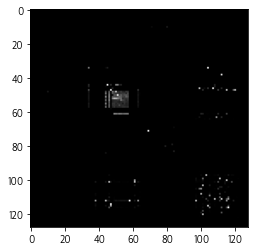

In [229]:
img = cv2.imread('../dataset/credential/img/point/train/1_attack/attack_0001.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [230]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    "../dataset/credential/img/point/train/",
    target_size=(128, 128),
    class_mode='binary',
    batch_size=16
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    "../dataset/credential/img/point/train/",
    target_size=(128, 128),
    class_mode='binary',
    batch_size=16
)

Found 2984 images belonging to 2 classes.
Found 2984 images belonging to 2 classes.


In [231]:
train_generator.class_indices.items()

dict_items([('0_normal', 0), ('1_attack', 1)])

In [232]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [242]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # 2 because we have cat and dog classes

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 56448)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               7225472   
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)              

In [243]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

epochs=100
history = model.fit(
    train_generator, 
    epochs=epochs,
    steps_per_epoch=16,
    validation_data = validation_generator,
    callbacks=callbacks
)

Epoch 1/100
16/16 [==============================] - 13s 794ms/step - loss: 1.0828 - accuracy: 0.6133 - val_loss: 0.7339 - val_accuracy: 0.5070
Epoch 2/100
16/16 [==============================] - 12s 746ms/step - loss: 0.9083 - accuracy: 0.7137 - val_loss: 0.6461 - val_accuracy: 0.8465
Epoch 3/100
16/16 [==============================] - 12s 739ms/step - loss: 0.7406 - accuracy: 0.6976 - val_loss: 0.8263 - val_accuracy: 0.1431
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7852
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 12s 736ms/step - loss: 0.5975 - accuracy: 0.7852 - val_loss: 0.6918 - val_accuracy: 0.2966
Epoch 5/100
16/16 [==============================] - 12s 742ms/step - loss: 0.6129 - accuracy: 0.7891 - val_loss: 0.5655 - val_accuracy: 0.8579
Epoch 6/100
16/16 [==============================] - 12s 745ms/step - loss: 0.5097 - accuracy: 0.8438 - val_loss: 0.5

In [244]:
model.save_weights('conan_credential_point_ver_01.h5')

In [248]:
test_filenames = os.listdir("../dataset/credential/img/point/test/")
test_filenames.remove('.DS_Store')
test_filenames

['2020-08-27_20-35-0.png',
 '2020-08-27_12-53-0.png',
 '2020-08-27_12-16-0.png',
 '2020-08-28_10-01-0.png',
 '2020-08-28_11-44-0.png',
 '2020-08-24_14-14-0.png',
 '2020-08-25_16-48-0.png',
 '2020-08-25_17-48-0.png',
 '2020-08-27_14-37-0.png',
 '2020-08-28_13-33-0.png',
 '2020-08-25_16-30-0.png',
 '2020-08-26_11-53-1.png',
 '2020-08-28_18-50-0.png',
 '2020-08-26_17-56-0.png',
 '2020-08-28_19-15-0.png',
 '2020-08-25_14-47-0.png',
 '2020-08-25_15-47-0.png',
 '2020-08-26_21-23-0.png',
 '2020-08-24_12-08-0.png',
 '2020-08-24_18-13-0.png',
 '2020-08-27_10-19-0.png',
 '2020-08-28_16-58-0.png',
 '2020-08-25_19-38-0.png',
 '2020-08-25_13-23-0.png',
 '2020-08-26_23-11-0.png',
 '2020-08-26_14-05-0.png',
 '2020-08-25_14-26-0.png',
 '2020-08-26_12-00-1.png',
 '2020-08-28_19-31-0.png',
 '2020-08-25_12-07-0.png',
 '2020-08-26_16-13-1.png',
 '2020-08-27_15-37-1.png',
 '2020-08-27_19-29-0.png',
 '2020-08-26_22-08-0.png',
 '2020-08-27_17-05-1.png',
 '2020-08-27_16-05-1.png',
 '2020-08-27_10-00-0.png',
 

In [249]:
test_df = pd.DataFrame({
    'filename': test_filenames
})
test_df

,filename
0,2020-08-27_20-35-0.png
1,2020-08-27_12-53-0.png
2,2020-08-27_12-16-0.png
3,2020-08-28_10-01-0.png
4,2020-08-28_11-44-0.png
...,...
614,2020-08-26_21-57-0.png
615,2020-08-26_16-43-1.png
616,2020-08-27_18-01-0.png
617,2020-08-26_14-55-0.png


In [250]:
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../dataset/credential/img/point/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size = 16,
    shuffle = False
)

Found 619 validated image filenames.


In [251]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/16))

In [252]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

{0: '0_normal', 1: '1_attack'}

<AxesSubplot:>

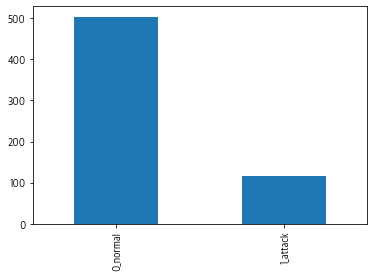

In [253]:
one = predict > 0.5

test_df['category'] = one

test_df['category'] = test_df['category'].replace(label_map)

test_df['category'].value_counts().plot.bar()

In [258]:
test_df.to_csv('credential-point-predict.csv')

In [321]:
test_df = pd.read_csv('credential-point-predict.csv', index_col = [0])
test_df.head()

,filename,category
0,2020-08-27_20-35-0.png,0_normal
1,2020-08-27_12-53-0.png,0_normal
2,2020-08-27_12-16-0.png,1_attack
3,2020-08-28_10-01-0.png,0_normal
4,2020-08-28_11-44-0.png,0_normal


In [323]:
test_df["predict"] = test_df["category"].replace({'0_normal': '0', '1_attack': '1'})
del test_df['category']
test_df.head()

,filename,predict
0,2020-08-27_20-35-0.png,0
1,2020-08-27_12-53-0.png,0
2,2020-08-27_12-16-0.png,1
3,2020-08-28_10-01-0.png,0
4,2020-08-28_11-44-0.png,0


In [333]:
test_df['actual'] = test_df['filename'].str[17:18]
test_df

,filename,predict,actual
0,2020-08-27_20-35-0.png,0,0
1,2020-08-27_12-53-0.png,0,0
2,2020-08-27_12-16-0.png,1,0
3,2020-08-28_10-01-0.png,0,0
4,2020-08-28_11-44-0.png,0,0
...,...,...,...
614,2020-08-26_21-57-0.png,0,0
615,2020-08-26_16-43-1.png,0,1
616,2020-08-27_18-01-0.png,0,0
617,2020-08-26_14-55-0.png,1,0


In [326]:
test_df[test_df['predict'] == '0']['actual'].value_counts()

0    460
1     43
Name: actual, dtype: int64

In [327]:
precision = 460 / 503
precision

0.9145129224652088

In [331]:
test_df[test_df['actual'] == '1']['predict'].value_counts()

1    52
0    43
Name: predict, dtype: int64

In [332]:
specificity = 52/95
specificity

0.5473684210526316

In [334]:
accuracy = 512/619
accuracy

0.827140549273021

### ResNet

In [335]:
from keras.applications.resnet50 import ResNet50

In [336]:
model_res = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 7s 0us/step


In [337]:
model_res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [339]:
from keras import layers
from keras import models

model2 = models.Sequential()

model2.add(model_res)

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 26,149,737
Trainable params: 26,096,617
Non-trainable params: 53,120
_________________________________________________________________


In [340]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [342]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

epochs=100
history = model2.fit(
    train_generator, 
    epochs=epochs,
    steps_per_epoch=16,
    validation_data = validation_generator,
    callbacks=callbacks
)

Epoch 1/100
16/16 [==============================] - 265s 17s/step - loss: 0.6181 - accuracy: 0.8164 - val_loss: 0.5689 - val_accuracy: 0.8569
Epoch 2/100
16/16 [==============================] - 310s 19s/step - loss: 0.5045 - accuracy: 0.8242 - val_loss: 0.5341 - val_accuracy: 0.8569
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8359
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16/16 [==============================] - 265s 17s/step - loss: 0.4211 - accuracy: 0.8359 - val_loss: 0.4106 - val_accuracy: 0.8569
Epoch 4/100
16/16 [==============================] - 301s 19s/step - loss: 0.3324 - accuracy: 0.8672 - val_loss: 0.4148 - val_accuracy: 0.8569
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8633

KeyboardInterrupt: 